In [143]:
import pandas as pd
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import ttest_ind, f_oneway
import time
from dotenv import load_dotenv
from tqdm import tqdm


In [132]:
# Set up the date range for the year
idx = pd.date_range(start='2023-01-01', end='2025-12-31', freq="h")

In [133]:
# Set a random seed for reproducibility
rng = np.random.default_rng(seed=42)

In [134]:
# Define the average wait times in minutes
mean_wait_time = 60

In [135]:
# Create a sine curve to reflect the changing average wait times throughout the day
# Simulate lower wait times during early morning and late night, higher in afternoon and evening
x = np.linspace(-np.pi, np.pi, 24)
means = (np.sin(x) * (mean_wait_time / 3)) + mean_wait_time

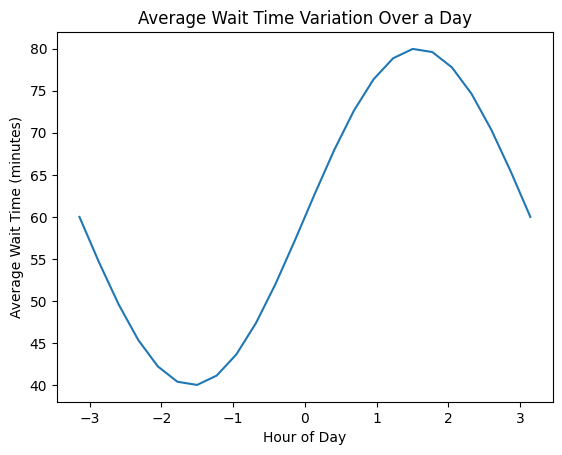

In [136]:
# Plot to visualize the average wait time pattern over a 24-hour period
plt.plot(x, means)
plt.title("Average Wait Time Variation Over a Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Wait Time (minutes)")
plt.show()

In [137]:
# Expanded the sine wave pattern to match the total number of data points in hours
number_of_days = len(idx) / 24
multiplier = (number_of_days * 2) - 1
x_extended = np.linspace(-np.pi, multiplier * np.pi, len(idx))
wait_time_means = (np.sin(x_extended) * (mean_wait_time / 3)) + mean_wait_time

In [138]:
# Generate wait times based on the Poisson distribution
df = pd.DataFrame(index=idx, data=rng.poisson(lam=wait_time_means, size=len(idx)), columns=["wait_time_minutes"])

In [146]:
import pandas as pd
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
from dotenv import load_dotenv
from tqdm import tqdm

# Load environment variables from the .env file
load_dotenv()
API_KEY = os.getenv('OPENWEATHER_API_KEY')
if not API_KEY:
    raise ValueError("API key not found. Please set the OPENWEATHER_API_KEY environment variable.")

# Constants
BASE_URL = 'https://api.openweathermap.org/data/2.5/weather'
latitude = 53.2707  # Galway latitude
longitude = -9.0568  # Galway longitude

# Set up the date range (daily frequency)
idx = pd.date_range(start='2023-01-01', end='2023-12-31', freq="D")

# CSV cache file to save weather data
csv_cache_filename = 'weather_cache_daily.csv'

# Load CSV cache if it exists, otherwise create an empty DataFrame
if os.path.exists(csv_cache_filename):
    weather_cache = pd.read_csv(csv_cache_filename, index_col='date', parse_dates=True)
    print(f"Loaded cached weather data from {csv_cache_filename}.")
else:
    weather_cache = pd.DataFrame(columns=['temperature', 'humidity', 'weather_condition'])
    print("No cache found. Starting fresh.")

# Function to fetch weather data for a given latitude and longitude
def get_weather_data(lat, lon):
    params = {
        'lat': lat,
        'lon': lon,
        'appid': API_KEY,
        'units': 'metric'
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        # Ensure required keys exist
        if 'main' in data and 'weather' in data:
            return data
        else:
            print(f"Invalid data structure received: {data}")
            return None
    else:
        print(f"Failed to fetch weather data. Status code: {response.status_code}, Response: {response.text}")
        return None

# Loop through each day to fetch weather data
weather_features = []

# Use tqdm for a progress bar
for day in tqdm(idx, desc="Fetching Weather Data"):
    # Check if data for this day is already in cache
    if day in weather_cache.index:
        # Fetch from cache
        temp = weather_cache.loc[day, 'temperature']
        humidity = weather_cache.loc[day, 'humidity']
        condition = weather_cache.loc[day, 'weather_condition']
    else:
        # Fetch data from the API
        weather_data = get_weather_data(latitude, longitude)

        if weather_data:
            # Extract relevant data
            temp = weather_data['main'].get('temp')
            humidity = weather_data['main'].get('humidity')
            condition = weather_data['weather'][0].get('main', 'Unknown')

            # Add to the cache
            new_data = pd.DataFrame({
                'temperature': [temp],
                'humidity': [humidity],
                'weather_condition': [condition]
            }, index=[day])
            if not new_data.empty:
                weather_cache = pd.concat([weather_cache, new_data], ignore_index=False)
        else:
            temp, humidity, condition = None, None, None  # Handle missing data

        # Add a delay to avoid API rate limits
        time.sleep(1)

    # Append to features list
    weather_features.append


No cache found. Starting fresh.


Fetching Weather Data:   0%|          | 0/365 [00:00<?, ?it/s]/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_49748/687304698.py:85: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  weather_cache = pd.concat([weather_cache, new_data], ignore_index=False)
/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_49748/687304698.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weather_cache = pd.concat([weather_cache, new_data], ignore_index=False)
Fetching Weather Data: 100%|██████████| 365/365 [07:40<00:00,  1.2

In [77]:
# Feature for the day of the week
df['day_of_week'] = df.index.day_name()

In [80]:
# Seasonality Feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

df['season'] = df.index.month.map(get_season)

# Print counts to verify if all seasons are represented
season_counts = df['season'].value_counts()
print("\nData Points per Season after reassignment:")
print(season_counts)

# Check that the data range includes months for each season:
print(f"Data Range Start: {df.index.min()}")
print(f"Data Range End: {df.index.max()}")
print(f"Unique Months in Data: {df.index.month.unique()}")

# Additional Debugging to Check Representation
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    count = df[df['season'] == season].shape[0]
    print(f"Data Points in {season}: {count}")

# If certain seasons are missing or underrepresented, consider rebalancing
missing_seasons = [season for season in ['Winter', 'Spring', 'Summer', 'Autumn'] if df[df['season'] == season].shape[0] == 0]
if missing_seasons:
    print(f"\nWarning: The following seasons are missing or underrepresented: {missing_seasons}")


Data Points per Season after reassignment:
season
Spring    6624
Summer    6624
Autumn    6552
Winter    6481
Name: count, dtype: int64
Data Range Start: 2023-01-01 00:00:00
Data Range End: 2025-12-31 00:00:00
Unique Months in Data: Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int32')
Data Points in Winter: 6481
Data Points in Spring: 6624
Data Points in Summer: 6624
Data Points in Autumn: 6552


In [81]:
# Holiday Feature
def is_holiday(date):
    holidays = [
        datetime(2023, 1, 1),  # New Year's Day
        datetime(2023, 3, 17), # St. Patrick's Day
        datetime(2023, 12, 25), # Christmas
        datetime(2023, 12, 26), # St. Stephen's Day
    ]
    return 1 if date.date() in [holiday.date() for holiday in holidays] else 0

df['is_holiday'] = df.index.map(is_holiday)

In [82]:
# Feature for full moon days
full_moon_dates = [
    datetime(2023, 1, 6), 
    datetime(2023, 2, 5),
    datetime(2023, 3, 7),
    datetime(2023, 4, 6),
    datetime(2023, 5, 5),
    datetime(2023, 6, 4),
    datetime(2023, 7, 3),
    datetime(2023, 8, 1),
    datetime(2023, 8, 30),
    datetime(2023, 9, 29),
    datetime(2023, 10, 28),
    datetime(2023, 11, 27),
    datetime(2023, 12, 26),
]

def is_full_moon(date):
    return 1 if date.date() in [full_moon.date() for full_moon in full_moon_dates] else 0

df['is_full_moon'] = df.index.map(is_full_moon)

In [84]:
# Day or Night feature
def day_or_night(hour):
    if 7 <= hour < 19:
        return 'Day'
    else:
        return 'Night'

df['day_or_night'] = df.index.hour.map(day_or_night)

In [85]:
# Adjust Wait Times for Weekends, Summer, and Winter
def adjust_wait_times(row):
    wait_time = row['wait_time_minutes']

    # Increase wait times by 20% for weekends
    if row['day_of_week'] in ['Saturday', 'Sunday']:
        wait_time *= 1.2

    # Increase wait times by 15% for Summer and Winter
    if row['season'] in ['Summer', 'Winter']:
        wait_time *= 1.15

    return wait_time

In [86]:
# Apply the adjustment function to create a new column with adjusted wait times
df['adjusted_wait_time_minutes'] = df.apply(adjust_wait_times, axis=1)

In [88]:
# Preview the updated DataFrame
print(df.head(10))

                     wait_time_minutes day_of_week  season  is_holiday  \
2023-01-01 00:00:00                 67      Sunday  Winter           1   
2023-01-01 01:00:00                 64      Sunday  Winter           1   
2023-01-01 02:00:00                 56      Sunday  Winter           1   
2023-01-01 03:00:00                 37      Sunday  Winter           1   
2023-01-01 04:00:00                 40      Sunday  Winter           1   
2023-01-01 05:00:00                 43      Sunday  Winter           1   
2023-01-01 06:00:00                 39      Sunday  Winter           1   
2023-01-01 07:00:00                 42      Sunday  Winter           1   
2023-01-01 08:00:00                 50      Sunday  Winter           1   
2023-01-01 09:00:00                 51      Sunday  Winter           1   

                     is_full_moon day_or_night  adjusted_wait_time_minutes  
2023-01-01 00:00:00             0        Night                       92.46  
2023-01-01 01:00:00            

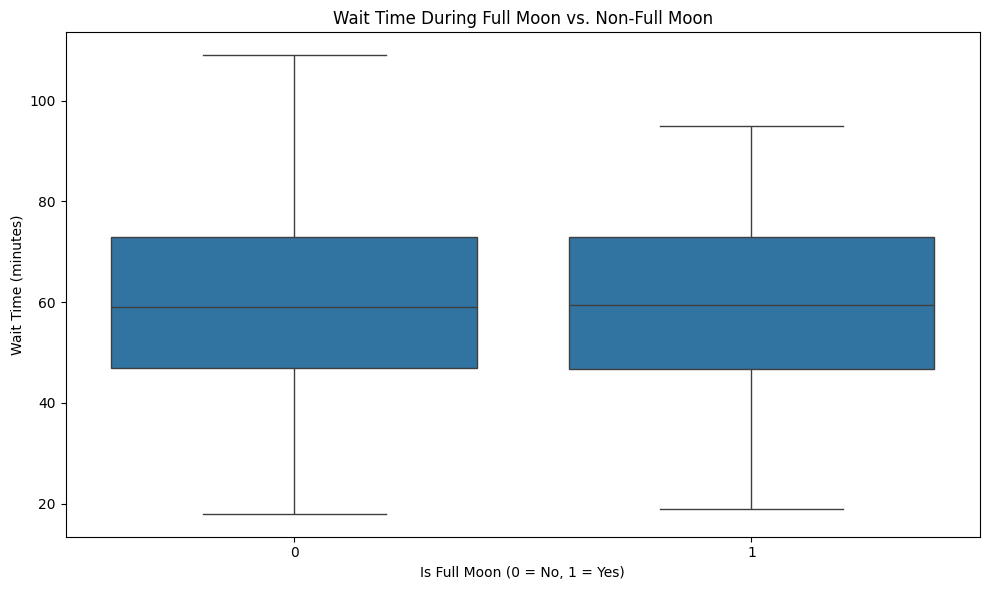

In [89]:
# Plot to visualize the wait times by whether it's a full moon
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_full_moon', y='wait_time_minutes', data=df)
plt.title("Wait Time During Full Moon vs. Non-Full Moon")
plt.xlabel("Is Full Moon (0 = No, 1 = Yes)")
plt.ylabel("Wait Time (minutes)")
plt.tight_layout()
plt.show()

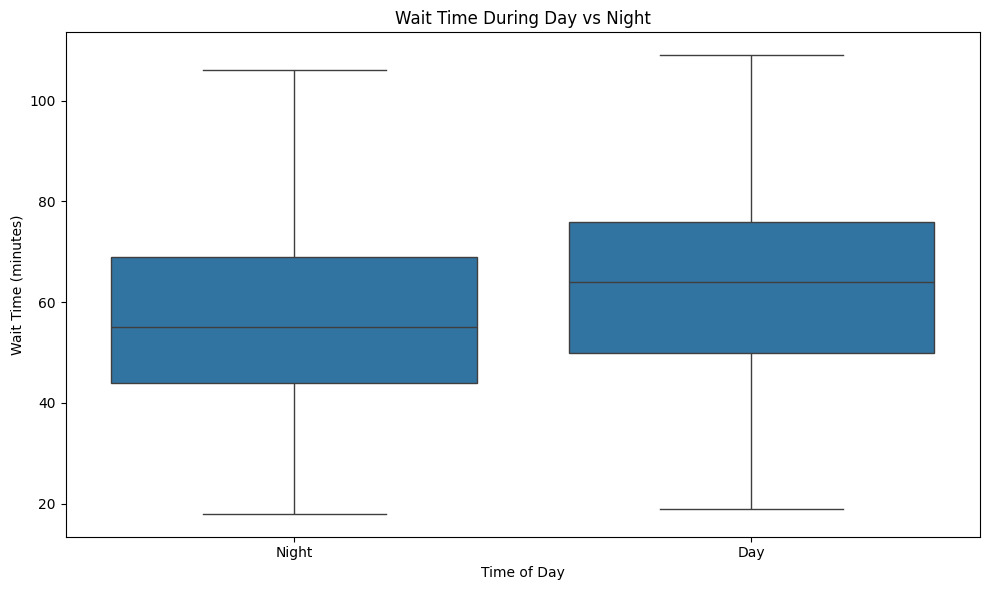

In [90]:
# Plot to visualize the wait times by day or night
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_or_night', y='wait_time_minutes', data=df)
plt.title("Wait Time During Day vs Night")
plt.xlabel("Time of Day")
plt.ylabel("Wait Time (minutes)")
plt.tight_layout()
plt.show()

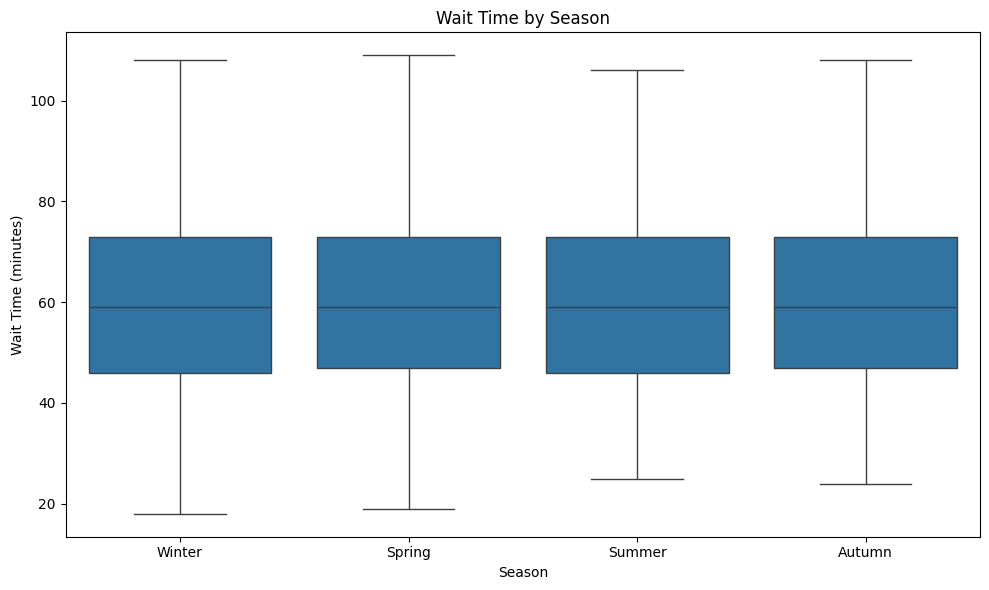

In [91]:
# Visualize Seasonal Impact on Wait Times
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='wait_time_minutes', data=df)
plt.title("Wait Time by Season")
plt.xlabel("Season")
plt.ylabel("Wait Time (minutes)")
plt.tight_layout()
plt.show()

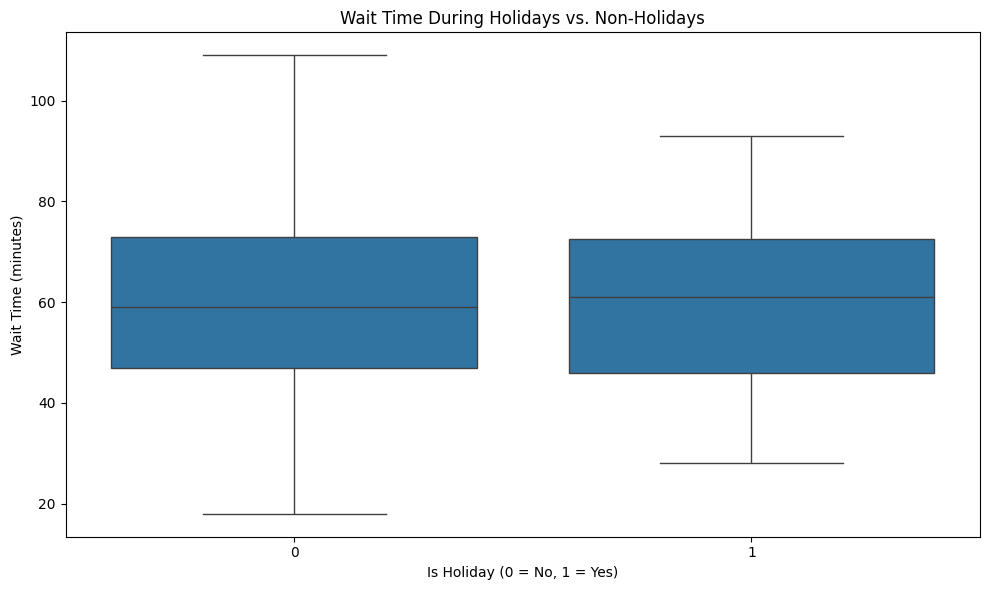

In [92]:
# Visualize Holiday Impact on Wait Times
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_holiday', y='wait_time_minutes', data=df)
plt.title("Wait Time During Holidays vs. Non-Holidays")
plt.xlabel("Is Holiday (0 = No, 1 = Yes)")
plt.ylabel("Wait Time (minutes)")
plt.tight_layout()
plt.show()

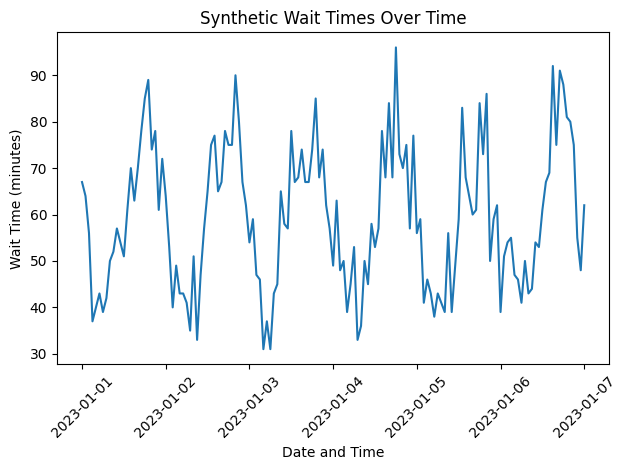

In [55]:
# Plot the synthetic data to see how the wait times fluctuate
sns.lineplot(data=df, x=df.index, y="wait_time_minutes")
plt.title("Synthetic Wait Times Over Time")
plt.xlabel("Date and Time")
plt.ylabel("Wait Time (minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [93]:
# Check the average wait time in the generated data
print("Average Wait Time:", df["wait_time_minutes"].mean())

Average Wait Time: 60.021117917887445


In [94]:
# Step 3.1: T-Test for Full Moon vs Non-Full Moon (using adjusted wait times)
full_moon_wait_times = df[df['is_full_moon'] == 1]['adjusted_wait_time_minutes']
non_full_moon_wait_times = df[df['is_full_moon'] == 0]['adjusted_wait_time_minutes']

t_stat, p_value = ttest_ind(full_moon_wait_times, non_full_moon_wait_times, equal_var=False)
print("T-Test Full Moon vs Non-Full Moon (Adjusted Wait Times):")
print("T-Statistic:", t_stat)
print("P-Value:", p_value)
if p_value < 0.05:
    print("There is a significant difference in adjusted wait times between full moon and non-full moon days.")
else:
    print("There is no significant difference in adjusted wait times between full moon and non-full moon days.")
print("\n")

# Step 3.2: ANOVA for Season Comparison (using adjusted wait times)
winter_wait_times = df[df['season'] == 'Winter']['adjusted_wait_time_minutes']
spring_wait_times = df[df['season'] == 'Spring']['adjusted_wait_time_minutes']
summer_wait_times = df[df['season'] == 'Summer']['adjusted_wait_time_minutes']
autumn_wait_times = df[df['season'] == 'Autumn']['adjusted_wait_time_minutes']

f_stat, p_value = f_oneway(winter_wait_times, spring_wait_times, summer_wait_times, autumn_wait_times)
print("ANOVA Test for Seasons (Adjusted Wait Times):")
print("F-Statistic:", f_stat)
print("P-Value:", p_value)
if p_value < 0.05:
    print("There is a significant difference in adjusted wait times between different seasons.")
else:
    print("There is no significant difference in adjusted wait times between different seasons.")
print("\n")

# Step 3.3: ANOVA for Day vs Night (using adjusted wait times)
day_wait_times = df[df['day_or_night'] == 'Day']['adjusted_wait_time_minutes']
night_wait_times = df[df['day_or_night'] == 'Night']['adjusted_wait_time_minutes']

f_stat, p_value = f_oneway(day_wait_times, night_wait_times)
print("ANOVA Test for Day vs Night (Adjusted Wait Times):")
print("F-Statistic:", f_stat)
print("P-Value:", p_value)
if p_value < 0.05:
    print("There is a significant difference in adjusted wait times between day and night.")
else:
    print("There is no significant difference in adjusted wait times between day and night.")

T-Test Full Moon vs Non-Full Moon (Adjusted Wait Times):
T-Statistic: 0.3509901379854859
P-Value: 0.7258279886072239
There is no significant difference in adjusted wait times between full moon and non-full moon days.


ANOVA Test for Seasons (Adjusted Wait Times):
F-Statistic: 507.79324538946645
P-Value: 8.266e-321
There is a significant difference in adjusted wait times between different seasons.


ANOVA Test for Day vs Night (Adjusted Wait Times):
F-Statistic: 971.9704905571286
P-Value: 1.4601467590177207e-209
There is a significant difference in adjusted wait times between day and night.


In [ ]:
import pandas as pd
from glob import glob
import os

# Directory where my monthly data files are stored
data_dir = '../data/'

# Find all Excel files for 2024 data
data_files = glob(os.path.join(data_dir, '*_2024_ae_data.xls'))

# Define headers
headers = [
    'Code', 'System', 'Type 1 Departments', 'Type 2 Departments', 'Type 3 Departments',
    'Total Attendances', 'Attendances < 4 hours (Type 1)', 'Attendances < 4 hours (Type 2)',
    'Attendances < 4 hours (Type 3)', 'Total Attendances < 4 hours', 'Attendances > 4 hours (Type 1)',
    'Attendances > 4 hours (Type 2)', 'Attendances > 4 hours (Type 3)', 'Total Attendances > 4 hours',
    'Percentage in 4 hours (all)', 'Percentage in 4 hours (Type 1)', 'Percentage in 4 hours (Type 2)',
    'Percentage in 4 hours (Type 3)', 'Emergency Admissions Type 1', 'Emergency Admissions Type 2',
    'Emergency Admissions Type 3 and 4', 'Total Emergency Admissions via A&E',
    'Other Emergency Admissions (not via A&E)', 'Total Emergency Admissions',
    'Patients spending >4 hours from decision to admit', 'Patients spending >12 hours from decision to admit'
]

# Initialize an empty list to store DataFrames for each file
all_data_frames = []

# Read and clean each file
for file in data_files:
    # Read Excel file with headers and skip metadata rows
    data = pd.read_excel(file, engine='xlrd', skiprows=17, header=None, names=headers)

    # Remove invalid rows
    data = data[data['System'].notna() & (data['System'] != '-')]

    # Convert relevant columns to numeric
    numeric_columns = [
        'Total Attendances', 'Total Attendances < 4 hours', 'Total Attendances > 4 hours',
        'Emergency Admissions Type 1', 'Patients spending >4 hours from decision to admit'
    ]
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Drop rows with missing required data
    data = data.dropna(subset=['Total Attendances', 'Total Attendances < 4 hours'])

    # Add 'Date' column for tracking month
    month = os.path.basename(file).split('_')[0]
    data['Date'] = pd.to_datetime(f"2024-{month}-01", format='%Y-%B-%d')

    # Add calculated fields (e.g., percentage of patients seen within 4 hours)
    data['Percentage_Under_4_Hours'] = (data['Total Attendances < 4 hours'] / data['Total Attendances']) * 100

    # Append cleaned data to the list
    all_data_frames.append(data)

# Combine all monthly data into a single DataFrame
combined_data = pd.concat(all_data_frames, ignore_index=True)

# Final cleaning (if needed)
combined_data = combined_data.dropna(subset=['System', 'Total Attendances'])

# Preview the combined data
print("\nCombined Data Preview:")
print(combined_data.head())

# Save combined data to CSV
combined_data.to_csv('../data/combined_2024_ae_data.csv', index=False)
print("Combined data saved to '../data/combined_2024_ae_data.csv'.")



Combined Data Preview:
  Code                                             System  Type 1 Departments  \
0  QOX  NHS Bath And North East Somerset, Swindon And ...             17493.0   
1  QHG  NHS Bedfordshire, Luton And Milton Keynes Inte...             23953.0   
2  QHL  NHS Birmingham And Solihull Integrated Care Board             37306.0   
3  QUY  NHS Bristol, North Somerset And South Gloucest...             23459.0   
4  QU9  NHS Buckinghamshire, Oxfordshire And Berkshire...             34233.0   

   Type 2 Departments  Type 3 Departments  Total Attendances  \
0               355.0             10293.0            28141.0   
1                 0.0             16524.0            40477.0   
2                 0.0             16376.0            53682.0   
3              2252.0              7594.0            33305.0   
4              5268.0              8500.0            48001.0   

   Attendances < 4 hours (Type 1)  Attendances < 4 hours (Type 2)  \
0                          9904.0  

In [24]:
# Calculate overall statistics
total_attendances = real_data['Total Attendances'].sum()
average_percentage_under_4_hours = real_data['Percentage_Under_4_Hours'].mean()

print(f"\nTotal Attendances in December 2024: {total_attendances}")
print(f"Average Percentage Seen Within 4 Hours: {average_percentage_under_4_hours:.2f}%")



Total Attendances in December 2024: 2345934.0
Average Percentage Seen Within 4 Hours: 70.04%


In [25]:
# Sort by percentage under 4 hours
sorted_data = real_data.sort_values('Percentage_Under_4_Hours', ascending=False)

print("\nTop 5 Hospital Systems by 4-hour Performance:")
print(sorted_data[['System', 'Percentage_Under_4_Hours']].head(5))

print("\nBottom 5 Hospital Systems by 4-hour Performance:")
print(sorted_data[['System', 'Percentage_Under_4_Hours']].tail(5))



Top 5 Hospital Systems by 4-hour Performance:
                                                System  \
NaN          NHS Kent And Medway Integrated Care Board   
NaN  NHS Cornwall And The Isles Of Scilly Integrate...   
NaN            NHS Black Country Integrated Care Board   
NaN        NHS North West London Integrated Care Board   
NaN          NHS Gloucestershire Integrated Care Board   

     Percentage_Under_4_Hours  
NaN                 78.922410  
NaN                 77.149056  
NaN                 76.532080  
NaN                 75.801297  
NaN                 75.288589  

Bottom 5 Hospital Systems by 4-hour Performance:
                                                System  \
NaN  NHS Cambridgeshire And Peterborough Integrated...   
NaN  NHS Staffordshire And Stoke-On-Trent Integrate...   
NaN  NHS Shropshire, Telford And Wrekin Integrated ...   
NaN  NHS Nottingham And Nottinghamshire Integrated ...   
NaN  NHS Herefordshire And Worcestershire Integrate...   

     Percenta

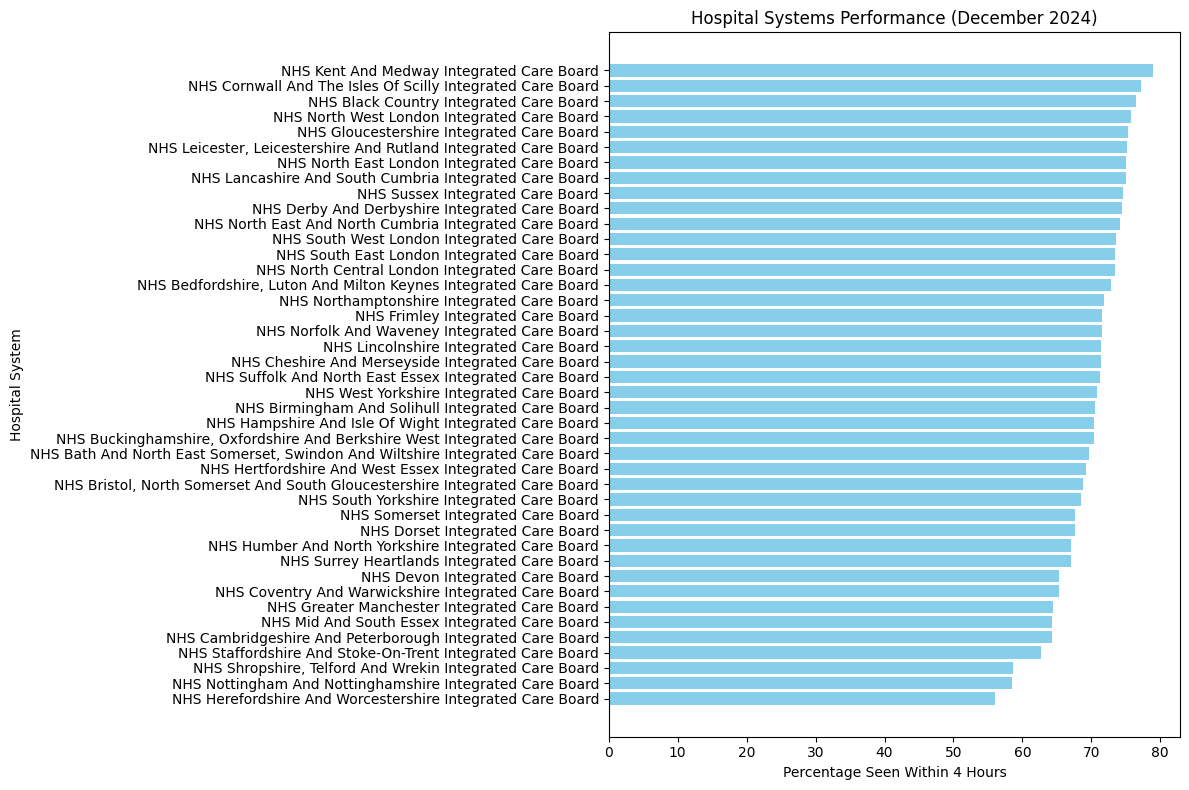

In [26]:
import matplotlib.pyplot as plt

# Sort and plot
sorted_data = real_data.sort_values('Percentage_Under_4_Hours')
plt.figure(figsize=(12, 8))
plt.barh(sorted_data['System'], sorted_data['Percentage_Under_4_Hours'], color='skyblue')
plt.xlabel('Percentage Seen Within 4 Hours')
plt.ylabel('Hospital System')
plt.title('Hospital Systems Performance (December 2024)')
plt.tight_layout()
plt.show()
